# Import Necessary Package

In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt  
import pandas as pd

# Load INCART Data

In [3]:
INCART = []
for i in range(1, 5):
    if i < 10:
        INCART.append('I0' + str(i))
    else:
        INCART.append('I' + str(i))
INCARTSet = {}

for ds in INCART:
    dataSetLoc = '' + ds
    record = wfdb.rdrecord(dataSetLoc)
    lead0 = record.p_signal[:,0]
    lead1 = record.p_signal[:,1]
    annotation = wfdb.rdann(dataSetLoc, 'atr')
    annIdx = annotation.sample
    annType = annotation.symbol
    INCARTSet[ds] = {'lead0': lead0, 'lead1': lead1, 'annIdx': annIdx, 'annType': annType}

In [5]:
record.p_signal[:,10]

array([2.05571566, 2.05283381, 2.02977906, ..., 1.11239193, 1.10854947,
       1.10470701])

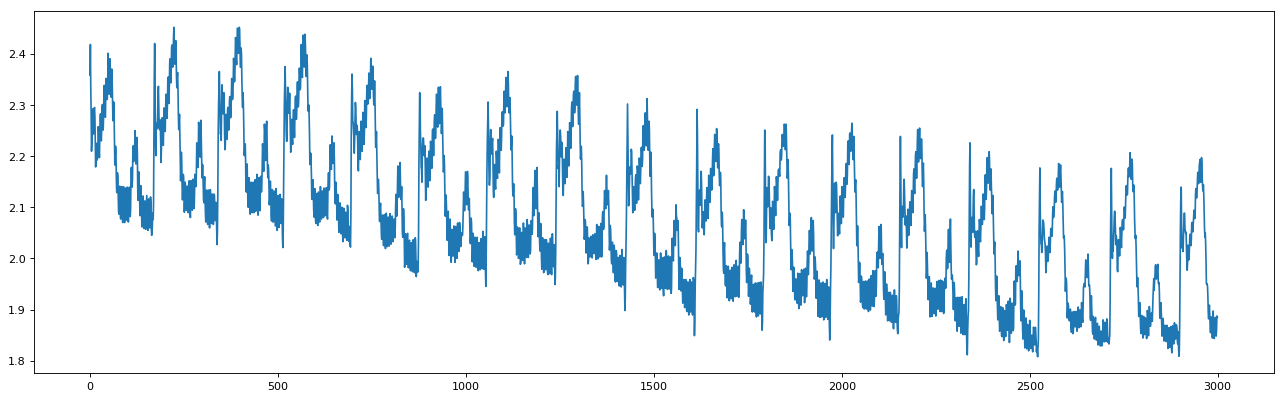

In [6]:
# check

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(INCARTSet['I03']['lead1'][:3000])
plt.show()

# Up Sampling

In [7]:
len(INCARTSet['I01']['annIdx'])

2757

In [8]:
for ds in INCART:
    newAnnIdx = []
    
    index = pd.date_range('1/1/2000', periods = len(INCARTSet[ds]['lead0']), freq='0.003891S')
    tempLead = pd.Series(INCARTSet[ds]['lead0'], index=index)
    resampled_tempLead = tempLead.resample('0.0028S').pad()
    INCARTSet[ds]['lead0'] = np.array(list(resampled_tempLead))
    
    for i in INCARTSet[ds]['annIdx']:
        if i == len(tempLead):
            newAnnIdx.append(len(resampled_tempLead))
            continue
        newAnnIdx.append(resampled_tempLead.index.get_loc(index[i], method='nearest'))
    INCARTSet[ds]['annIdx'] = np.array(newAnnIdx)
    
    index = pd.date_range('1/1/2000', periods = len(INCARTSet[ds]['lead1']), freq='0.003891S')
    tempLead = pd.Series(INCARTSet[ds]['lead1'], index=index)
    resampled_tempLead = tempLead.resample('0.0028S').pad()
    INCARTSet[ds]['lead1'] = np.array(list(resampled_tempLead))

In [9]:
len(INCARTSet['I01']['annIdx'])

2757

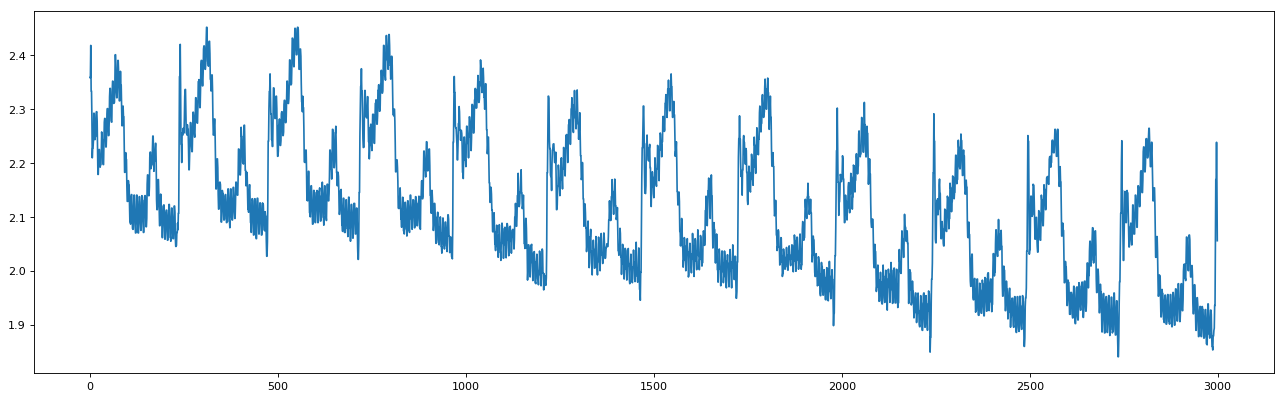

In [10]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(INCARTSet['I03']['lead1'][:3000])
plt.show()

# Data Denoising

## Baseline Wander Removal

In [11]:
for k, v in INCARTSet.items():
    print(k)
    first_filtered = medfilt(v['lead0'],71)
    second_filtered = medfilt(first_filtered,215)
    v['lead0'] = v['lead0'] - second_filtered

    first_filtered = medfilt(v['lead1'],71)
    second_filtered = medfilt(first_filtered,215)
    v['lead1'] = v['lead1'] - second_filtered

I03
I02
I04
I01


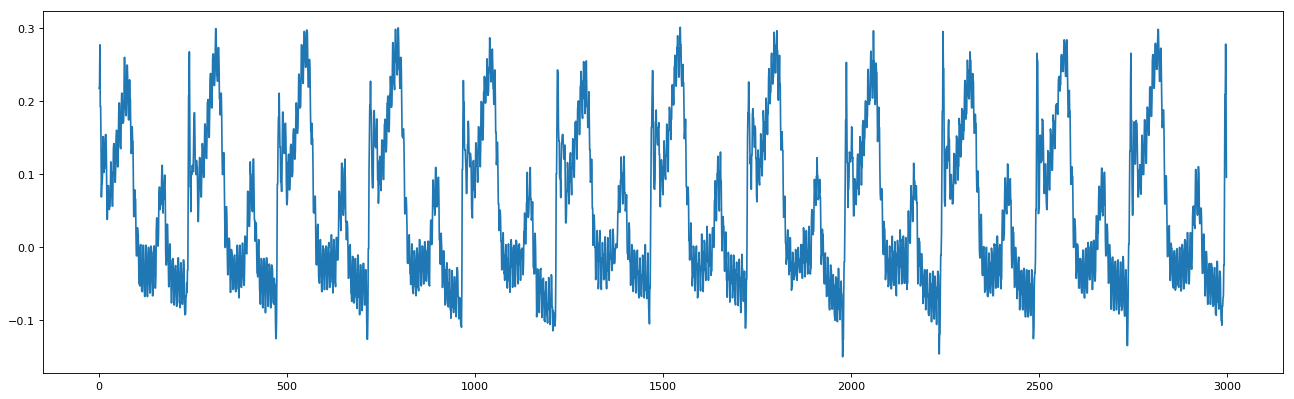

In [12]:
# 测试数据集的去噪情况

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(INCARTSet['I03']['lead1'][:3000])
plt.show()

## High Frequency Noise Removal in Use of Wavelets Transformation

In [13]:
def wt(index_list,wavefunc,lv,m,n):   
   

    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   

    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 


    for i in range(m,n+1):   
        cD = coeff[i]
        for j in range(len(cD)):
            Tr = np.sqrt(2*np.log(len(cD)))  
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) - Tr  
            else:
                coeff[i][j] = 0   


    denoised_index = pywt.waverec(coeff,wavefunc)
    return denoised_index

I03
I02
I04
I01


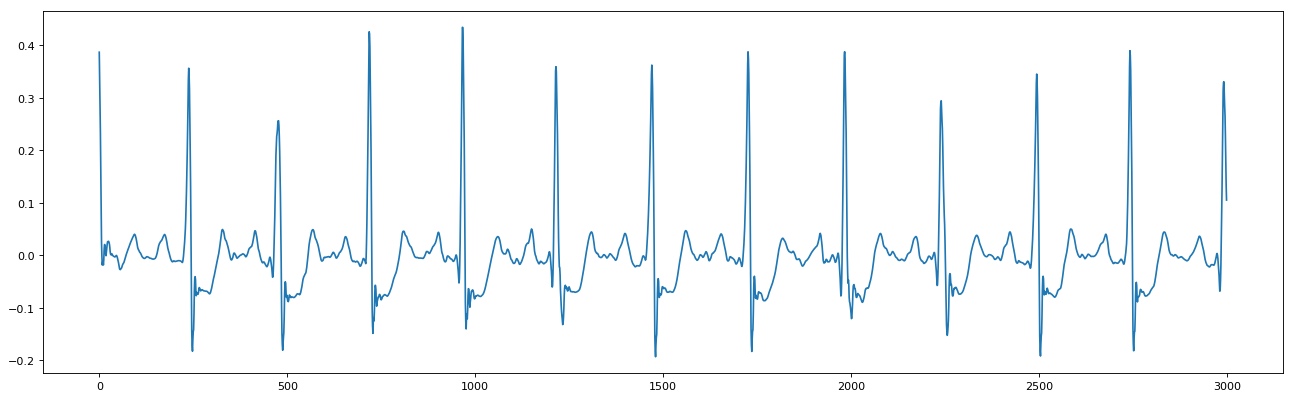

In [14]:
for k, v in INCARTSet.items():
    print(k)
    v['lead0'] = wt(v['lead0'],'db4',4,2,4)
    v['lead1'] = wt(v['lead1'],'db4',4,2,4)

# check

plt.figure(figsize=(20, 6), dpi=80)
plt.plot(INCARTSet['I03']['lead0'][:3000])
plt.show()

# Save Cleaned Data to CSV

In [16]:
headers = ['lead0', 'lead1', 'annIdx', 'annType']

for k, v in INCARTSet.items():
    df1 = pd.DataFrame({ 'lead0': INCARTSet[k]['lead0'], 'lead1': INCARTSet[k]['lead1']})
    df1.to_csv('C:/Users/Sam/Desktop/Data/Cleaned INCART/' + k + '_lead.csv', index=False)
    
    df2 = pd.DataFrame({ 'annIdx': INCARTSet[k]['annIdx'], 'annType': INCARTSet[k]['annType']})
    df2.to_csv('C:/Users/Sam/Desktop/Data/Cleaned INCART/' + k + '_ann.csv', index=False)

In [17]:
# 测试存储情况
df_lead = pd.read_csv('C:/Users/Sam/Desktop/Data/Cleaned INCART/I01_lead.csv')
df_ann = pd.read_csv('C:/Users/Sam/Desktop/Data/Cleaned INCART/I01_ann.csv')
df_lead
df_ann

,annIdx,annType
0,158,N
1,385,N
2,614,N
3,845,N
4,987,V
5,1308,N
6,1537,N
7,1763,N
8,1994,N
9,2218,N


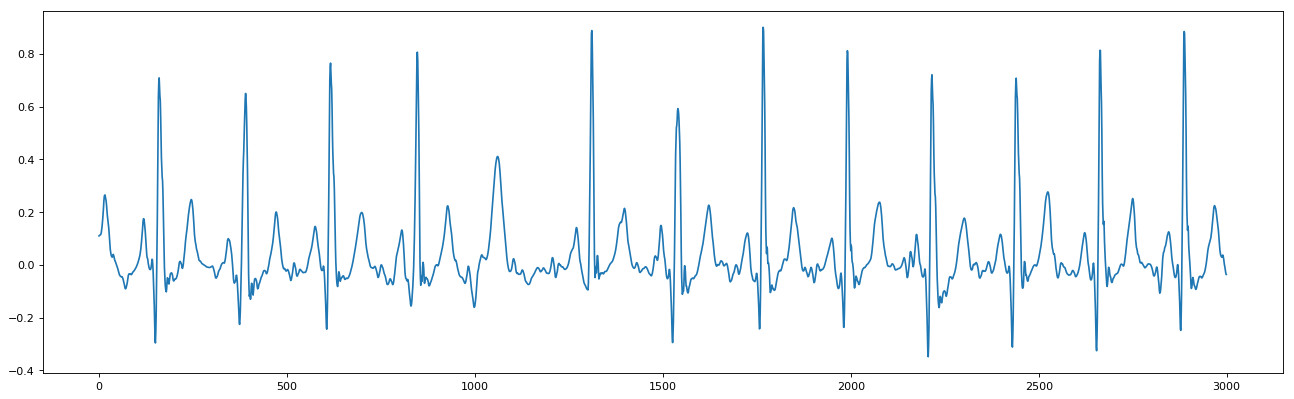

In [18]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(df_lead['lead0'][:3000])
plt.show()